jupyter:
  jupytext:
    default_lexer: python
    text_representation:
      extension: .md
      format_name: markdown
      format_version: '1.3'
      jupytext_version: 1.18.1
  kernelspec:
    display_name: Python 3 (ipykernel)
    language: python
    name: python3
---

# Object Detection: A Comparison of YOLO and DETR

This notebook introduces and compares two prominent object detection architectures: YOLO (You Only Look Once) and DETR (Real-Time DEtection TRansformer). We will use pretrained models to perform inference on the ENA24 dataset and analyze their performance, paying special attention to the challenges posed by the mismatch between the models' training classes (COCO) and the dataset's actual classes.

Object detection is a computer vision task that involves identifying and locating objects within an image. A model performing this task returns a set of bounding boxes, each with a corresponding class label for the object it contains.

We will explore:
*   **YOLO**: A leading family of single-stage detectors known for its speed and efficiency.
*   **DETR**: A modern, transformer-based, end-to-end detector that provides high accuracy without requiring complex post-processing steps like Non-Maximum Suppression (NMS).
*   **The ENA24 Dataset**: We will use the `imageomics/IDLE-OO-Camera-Traps` dataset to evaluate how well these models, pretrained on general-purpose datasets, perform on specialized data.

## 1. Setup

First, let's install the necessary libraries. `ultralytics` provides the YOLO model, while `transformers` gives us access to DETR.

In [1]:
!pip install -q ultralytics transformers timm datasets torch torchvision Pillow scikit-learn seaborn pandas matplotlib

Now, let's import all the required modules.

In [2]:
import torch

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from datasets import load_dataset
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import requests
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import cv2
import tqdm

# YOLO imports
from ultralytics import YOLO

# DETR imports
from transformers import DetrImageProcessor, DetrForObjectDetection

Using device: cuda


/home/joosep/env-ai-course/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Loading the Dataset and a Sample Image

We'll load the `imageomics/IDLE-OO-Camera-Traps` dataset from a local path and select one example from the test split to use for our initial inference examples.

Loaded image: ../data/IDLE-OO-Camera-Traps/data/test/desert-lion/8b0146e9-3117-4d76-b61c-a8ead22e5755.png


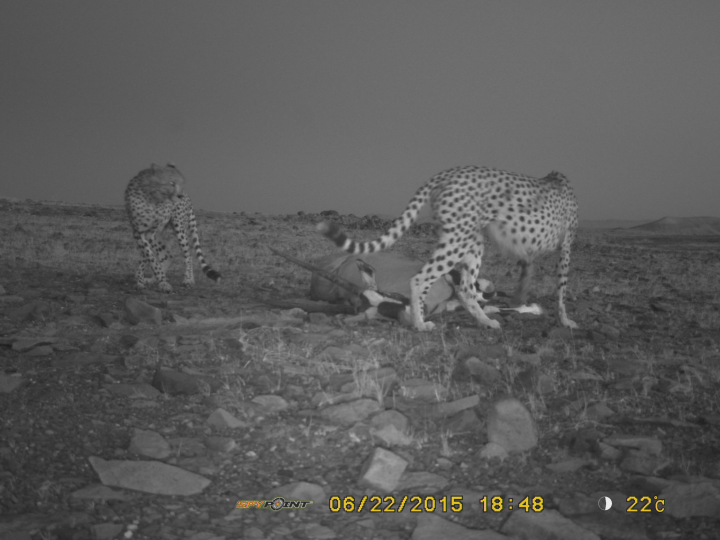

In [3]:
image_path = "../data/IDLE-OO-Camera-Traps/data/test/desert-lion/8b0146e9-3117-4d76-b61c-a8ead22e5755.png"
image = Image.open(image_path).convert("RGB")
print(f"Loaded image: {image_path}")
display(image)

## 3. Part 1: YOLO (You Only Look Once)

The YOLO family of models are "single-stage" detectors, meaning they predict bounding boxes and class probabilities directly from the image in a single pass. They are famously fast and have become an industry standard for real-time object detection.

### 3.1. Inference with YOLOv8

The `ultralytics` library makes it incredibly simple to load a pretrained YOLO model and run inference. We'll use `yolov8n.pt`, a nano-sized version of the model that is fast and lightweight.

The model is pretrained on the COCO dataset, a large-scale object detection dataset with 80 common object classes like "person," "car," and "dog."


0: 480x640 2 giraffes, 24.9ms
Speed: 1.7ms preprocess, 24.9ms inference, 11.9ms postprocess per image at shape (1, 3, 480, 640)
YOLOv8 Detections (Confidence > 0.5):


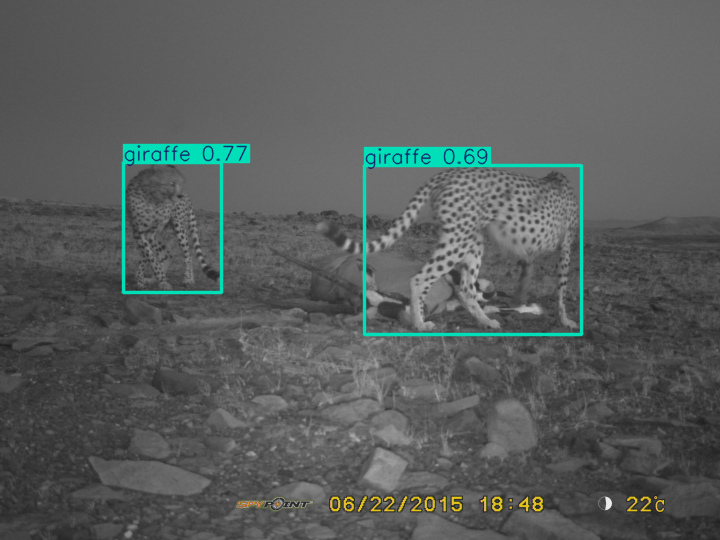

In [4]:
# Load a pretrained YOLOv8 model
model_yolo = YOLO('../yolov8n.pt').to(device)

# Run inference on a copy of the image
results_yolo = model_yolo(image.copy(), conf=0.5)

# The `plot()` method conveniently draws the detected boxes on the image
im_array = results_yolo[0].plot()
im_yolo = Image.fromarray(im_array[..., ::-1])  # Convert to RGB PIL image

print("YOLOv8 Detections (Confidence > 0.5):")
display(im_yolo)

### 3.2. YOLO Architectural Deep Dive

YOLO's architecture is a masterclass in efficiency, designed to perform detection in a single forward pass. It consists of three primary components: the Backbone, the Neck, and the Head.

*   **Backbone (CSPDarknet):** The backbone is a deep Convolutional Neural Network (CNN) responsible for extracting features from the input image at various scales. It starts with a `Stem` layer for initial downsampling, followed by a series of convolutional blocks (`C2f` in YOLOv8). As the image passes through the backbone, its spatial dimensions (height and width) are reduced, while the number of channels (feature depth) is increased. This process creates a hierarchy of feature maps: early layers capture low-level features like edges and textures, while deeper layers capture high-level semantic features like object parts.

*   **Neck (PANet):** The neck's job is to fuse the feature maps from the backbone to create a feature pyramid that is rich in both semantic (what) and localization (where) information. YOLOv8 uses a Path Aggregation Network (PANet). It takes feature maps from different stages of the backbone and combines them through both a top-down path (bringing high-level context to lower-level maps) and a bottom-up path (bringing precise localization information from lower-level maps to higher-level ones). This allows the model to effectively detect objects of different sizes.

*   **Head (YOLOv8 Head):** The head is the final stage, responsible for making predictions. It takes the fused feature maps from the neck and uses a series of convolutions to predict three things for each location on the feature grid:
    1.  **Bounding Box:** The coordinates (x, y, width, height) of a potential object.
    2.  **Objectness Score:** A confidence score indicating how likely it is that an object exists at this location.
    3.  **Class Probabilities:** A set of probabilities for each of the 80 COCO classes.

#### Output Interpretation and NMS

The raw output of the YOLO head is a massive tensor containing thousands of potential detections at different scales. To produce a clean, final list of objects, a critical post-processing step is required: **Non-Maximum Suppression (NMS)**. NMS works by:
1.  Filtering out boxes with low confidence scores.
2.  For each class, finding groups of overlapping boxes that likely correspond to the same object.
3.  Within each group, suppressing (discarding) all boxes except the one with the highest confidence score.

The `ultralytics` library handles all of this automatically when you call the model.

#### Visualizing Intermediate Features

To better understand what the model "sees," we can extract the feature maps from intermediate layers and visualize them. We will use Principal Component Analysis (PCA) to reduce the high-dimensional channel information of a feature map into 3 components (RGB) for visualization.

We'll grab features from three different points in the network:
1.  An early backbone layer (`C2f_2`)
2.  A later backbone layer (`C2f_4`)
3.  The output of a neck layer (`C2f_6`)

PCA Visualization of YOLOv8 Intermediate Features:
feat (32, 120, 160)


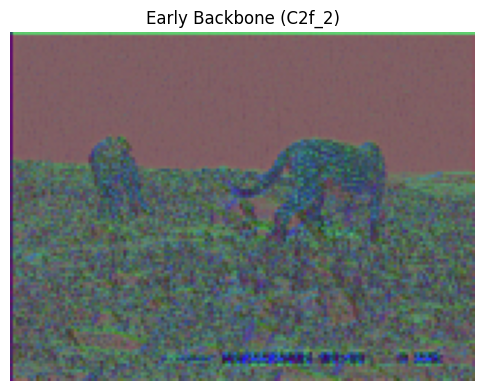

feat (64, 60, 80)


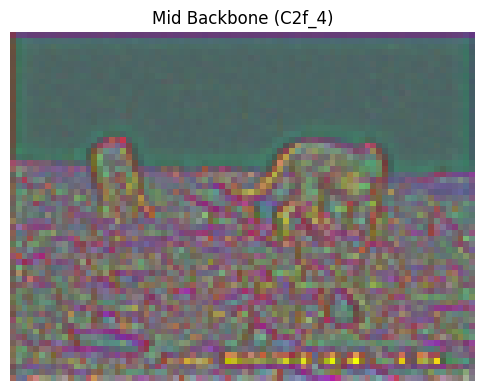

feat (128, 30, 40)


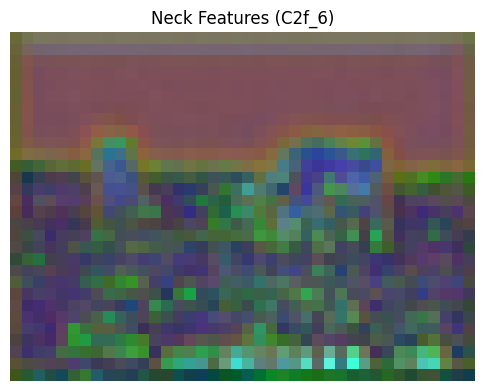

In [5]:
# Helper function to visualize a feature map using PCA
def visualize_features_pca(feature_map, title):
    # Detach from graph and move to CPU
    features = feature_map.squeeze(0).cpu().numpy()
    
    # Reshape for PCA: (H*W, C)
    # The input shape is (C, H, W), so we transpose it to (H, W, C) first
    print("feat", features.shape)
    features = features.transpose(1, 2, 0)
    h, w, c = features.shape
    reshaped_features = features.reshape(-1, c)
    
    # Apply PCA to reduce channels to 3 components
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(reshaped_features)
    
    # Normalize and reshape back to an image (H, W, 3)
    pca_img = (pca_result - pca_result.min()) / (pca_result.max() - pca_result.min())
    pca_img = pca_img.reshape(h, w, 3)
    
    # Display
    plt.figure(figsize=(6, 6))
    plt.imshow(pca_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- YOLO Feature Extraction ---

# Dictionary to store intermediate features
yolo_features = {}

# Hook function to capture the output of a module
def get_yolo_hook(name):
    def hook(model, input, output):
        # For C2f modules, the output might be a tuple/list, we take the first tensor
        if isinstance(output, (list, tuple)):
            yolo_features[name] = output[0].detach()
        else:
            yolo_features[name] = output.detach()
    return hook

# Mapping friendly names to actual module names in the YOLOv8 model structure
# The indices [2], [4], [6] correspond to early backbone, late backbone, and neck layers
yolo_layer_map = {
    "Early Backbone (C2f_2)": model_yolo.model.model[2],
    "Mid Backbone (C2f_4)": model_yolo.model.model[4],
    "Neck Features (C2f_6)": model_yolo.model.model[6],
}

# Register forward hooks on the target layers
hooks = []
for name, layer in yolo_layer_map.items():
    hooks.append(layer.register_forward_hook(get_yolo_hook(name)))

# Run inference on the sample image to trigger the hooks
# We use the original `image` from the dataset
results_yolo = model_yolo(image.copy(), verbose=False)

# Remove the hooks now that we have the features
for hook in hooks:
    hook.remove()

# Visualize the captured features
print("PCA Visualization of YOLOv8 Intermediate Features:")
for name, features in yolo_features.items():
    visualize_features_pca(features, name)

## 4. Part 2: DETR (DEtection TRansformer)

DETR (DEtection TRansformer) models reframe object detection as a direct set prediction problem. They use a transformer-based architecture to produce a fixed-size set of predictions, eliminating the need for complex post-processing like NMS. DETR is an evolution of this idea, optimized for real-time performance.

### 4.1. Inference with DETR

We will use the `transformers` library to load a pretrained DETR model. Unlike YOLO, DETR models require a specific `processor` to resize and normalize the input image correctly.

DETR Top 2 Detections:


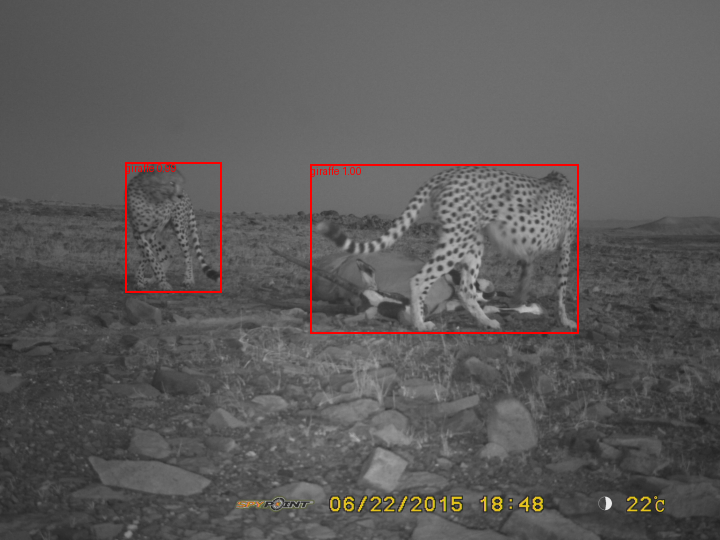

In [6]:
# Load the processor and a pretrained DETR model from Hugging Face
processor_detr = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model_detr = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm").to(device)

# Prepare the image for the model
inputs = processor_detr(images=image, return_tensors="pt").to(device)

# Run inference
with torch.no_grad():
    outputs = model_detr(**inputs)

# Post-process the results to get bounding boxes and class labels
# We set a low threshold to get all potential detections, then we'll select the top 3.
target_sizes = torch.tensor([image.size[::-1]]).to(device)
results_detr = processor_detr.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.1)[0]

# Helper function to draw bounding boxes
def draw_boxes(image, boxes, labels, scores):
    img_draw = image.copy()
    draw = ImageDraw.Draw(img_draw)
    for box, label, score in zip(boxes, labels, scores):
        box = [round(i, 2) for i in box.tolist()]
        label_text = f"{label} {score:.2f}"
        
        draw.rectangle(box, outline="red", width=2)
        draw.text((box[0], box[1]), label_text, fill="red")
    return img_draw

# Get labels, scores, and boxes for the top 3 detections
scores = results_detr["scores"]
labels = results_detr["labels"]
boxes = results_detr["boxes"]

TOP_K = 3
k = min(len(scores), TOP_K)

scores, indices = torch.topk(scores, k)
labels = labels[indices]
boxes = boxes[indices]

# Convert label IDs to names
labels = [model_detr.config.id2label[i.item()] for i in labels]

# Draw the boxes on the image
im_detr = draw_boxes(image, boxes, labels, scores)

print(f"DETR Top {k} Detections:")
display(im_detr)

### 4.2. DETR Architectural Deep Dive

The DETR architecture introduced a paradigm shift by framing object detection as a direct set prediction problem, removing the need for many hand-designed components like NMS.

*   **Backbone (ResNet):** It begins with a standard CNN backbone (a ResNet-50 in this case) to extract a 2D feature map from the input image. This feature map captures the essential spatial features.

*   **Transformer Encoder:** This is where DETR diverges significantly.
    *   **Input:** The feature map from the backbone is flattened into a sequence of tokens. Crucially, these tokens are combined with **Positional Encodings**, which are vectors that give the model information about the original `(x, y)` position of each token. Without this, the transformer would be unaware of the image's spatial structure.
    *   **Function:** The encoder processes this sequence using multiple layers of self-attention. This allows every feature token to attend to every other token, building a rich, context-aware representation. The output is an enriched sequence of image features.

*   **Transformer Decoder:** The decoder is the core of the prediction mechanism.
    *   **Input:** It takes two main inputs: the memory of enriched features from the encoder, and a small, fixed-size set of learnable embeddings called **Object Queries**.
    *   **Function:** Each object query acts as a "slot" responsible for detecting a single object. Through layers of self-attention and cross-attention, the queries interact with each other (to avoid duplicates) and with the encoder's output (to find and localize objects). Each query "asks" the image features: "Is there an object here that matches my pattern?"
    
*   **Prediction Heads (FFNs):** After the final decoder layer, each output query embedding is passed to two separate Feed-Forward Networks (FFNs):
    1.  A **classification head** predicts the class label for that query (e.g., 'bird', 'car', or 'no object').
    2.  A **box head** predicts the bounding box coordinates `(center_x, center_y, width, height)`.

#### End-to-End Philosophy

This design is "end-to-end" because it directly outputs a sparse set of predictions. Since each query is encouraged to specialize on a different object, the model learns to avoid making duplicate predictions for the same object, thus eliminating the need for NMS.


#### Visualizing Attention Maps

Running inference with attentions...
Generating Cross-Attention Maps...
Rank 1: giraffe | Score: 1.00 | Query Index: 98
Rank 2: giraffe | Score: 0.99 | Query Index: 61
Rank 3: giraffe | Score: 0.01 | Query Index: 84


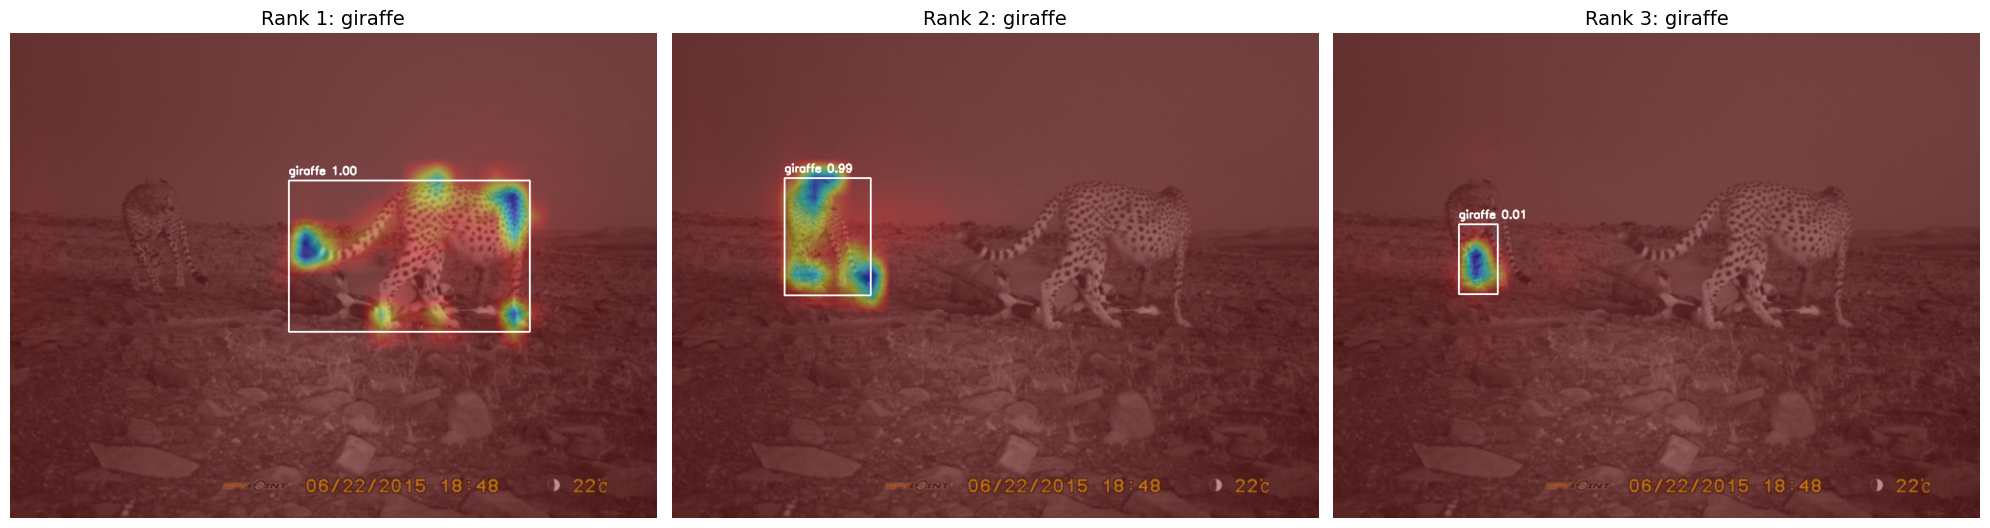

In [7]:
# --- STEP 1: INFERENCE WITH ATTENTIONS ---
# We must request output_attentions=True to get the internal weights
print("Running inference with attentions...")
with torch.no_grad():
    outputs = model_detr(**inputs, output_attentions=True)
    
    # 1. Get Probabilities and Top K
    probs = outputs.logits.softmax(-1)[0, :, :-1]
    max_scores, class_ids = probs.max(-1)
    TOP_K = 3
    top_scores, top_idxs = torch.topk(max_scores, TOP_K)

# --- STEP 2: PROCESS ATTENTION MAPS ---
print("Generating Cross-Attention Maps...")

# Get the Cross-Attentions from the LAST decoder layer
# Shape: (Batch, Num_Heads, Num_Queries, Sequence_Length)
# Sequence_Length = Feature_Height * Feature_Width (usually H/32 * W/32)
cross_attentions = outputs.cross_attentions[-1]

# Get input image dimensions
img_h, img_w = inputs['pixel_values'].shape[-2:]

# Prepare background image for visualization
img_tensor = inputs['pixel_values'][0].detach().cpu()
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
rgb_img_base = (img_tensor * std + mean).permute(1, 2, 0).numpy()
rgb_img_base = np.clip(rgb_img_base, 0, 1)

# Setup Plot
fig, axes = plt.subplots(1, TOP_K, figsize=(20, 6))
if TOP_K == 1: axes = [axes]

for i, query_idx_tensor in enumerate(top_idxs):
    query_idx = query_idx_tensor.item()
    class_id = class_ids[query_idx].item()
    score = top_scores[i].item()
    label_name = model_detr.config.id2label[class_id]

    print(f"Rank {i+1}: {label_name} | Score: {score:.2f} | Query Index: {query_idx}")

    # 1. Extract Attention for this specific Query
    # Shape: [Batch, Heads, Queries, Seq] -> [Heads, Seq]
    attn_map = cross_attentions[0, :, query_idx, :]
    
    # 2. Average over Attention Heads
    # Shape: [Seq]
    attn_map = attn_map.mean(dim=0).detach().cpu()

    # 3. Reshape Sequence back to 2D Feature Map
    # We infer the feature map size (H/32, W/32)
    feat_h = int(np.ceil(img_h / 32))
    feat_w = int(np.ceil(img_w / 32))
    
    # Handle potential mismatch due to padding/rounding
    num_patches = feat_h * feat_w
    # DETR sometimes pads the mask, so we strictly reshape to what matches the sequence length
    # If exact match isn't possible, we calculate approximate square side
    if attn_map.shape[0] != num_patches:
       # Fallback for edge cases: assume roughly square aspect ratio
       side = int(attn_map.shape[0]**0.5)
       feat_h, feat_w = side, side

    attn_map = attn_map.reshape(feat_h, feat_w).numpy()

    # 4. Process for Visualization
    # Resize to original image size
    attn_map = cv2.resize(attn_map, (img_w, img_h))
    
    # Normalize 0-1
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())
    
    # Apply ColorMap
    heatmap = np.uint8(255 * attn_map)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay
    visualization = cv2.addWeighted(np.uint8(255 * rgb_img_base), 0.6, heatmap, 0.4, 0)

    # 5. Draw Box
    pred_box = outputs.pred_boxes[0, query_idx].detach().cpu().numpy()
    cx, cy, w_box, h_box = pred_box
    x1 = int((cx - w_box / 2) * img_w)
    y1 = int((cy - h_box / 2) * img_h)
    x2 = int((cx + w_box / 2) * img_w)
    y2 = int((cy + h_box / 2) * img_h)

    cv2.rectangle(visualization, (x1, y1), (x2, y2), (255, 255, 255), 2)
    
    # Label
    label_text = f"{label_name} {score:.2f}"
    cv2.putText(visualization, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    axes[i].imshow(visualization)
    axes[i].axis('off')
    axes[i].set_title(f"Rank {i+1}: {label_name}", fontsize=14)

plt.tight_layout()
plt.show()

## 5. Comparative Analysis on the ENA24 Dataset

Both models are powerful, but how do they perform on a real-world, specialized dataset like ENA24? A key challenge is that they were trained on COCO's 80 classes, which do not directly align with the animal species in ENA24.

### 5.1. The Class Mismatch Problem

Let's look at the classes in the ENA24 dataset. We expect the models to either fail to detect anything or to classify an ENA24 animal as a "related" COCO class (e.g., classifying a "deer" as a "cow" or "horse").

Visualizing 'common_name' frequency in the ENA24 Dataset:


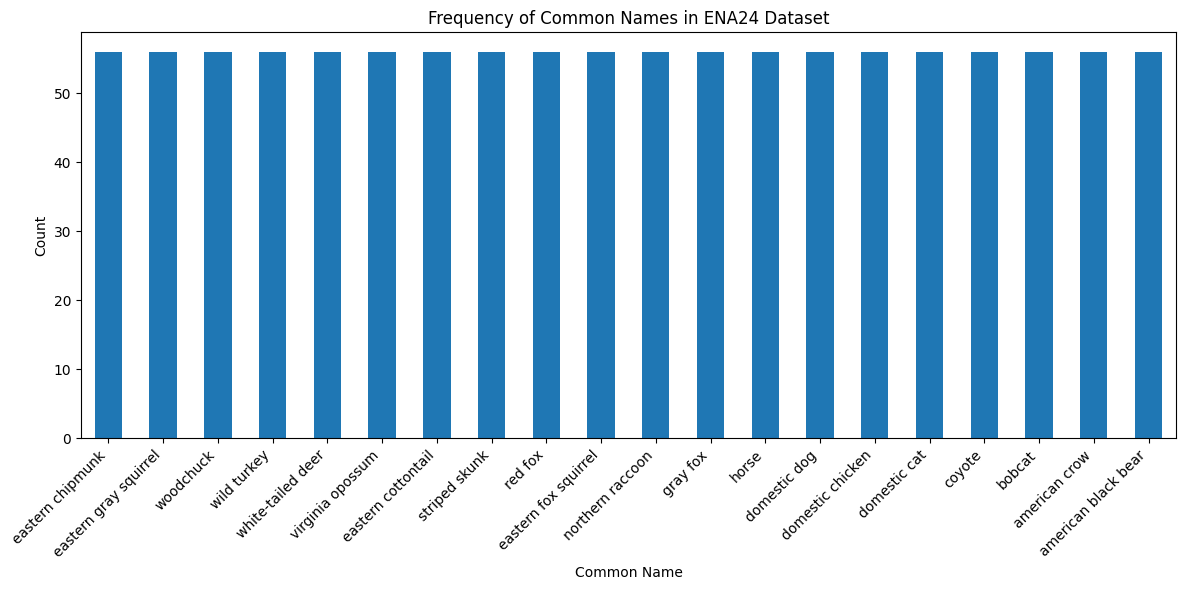

In [8]:
# Define the base path and load the ENA24 metadata
base_data_path = '../data/IDLE-OO-Camera-Traps/'
ena24_csv_path = os.path.join(base_data_path, 'ENA24-balanced.csv')
ena24_df = pd.read_csv(ena24_csv_path)

# --- Visualize "common_name" frequency ---
print("Visualizing 'common_name' frequency in the ENA24 Dataset:")
plt.figure(figsize=(12, 6))
ena24_df['common_name'].value_counts().plot(kind='bar')
plt.title('Frequency of Common Names in ENA24 Dataset')
plt.xlabel('Common Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 5.2. Performance Evaluation

We will now iterate through a sample of the ENA24 dataset, run both models on each image, and record the ground truth class and the top predicted COCO class. This will allow us to see which COCO classes the models associate with the ENA24 animals.

In [9]:
y_true = []
y_pred_yolo = []
y_pred_detr = []

# Let's take a few images per class for our analysis
num_samples_per_class = 5
unique_common_names = ena24_df['common_name'].unique()

for name in unique_common_names:
    sample_images = ena24_df[ena24_df['common_name'] == name].head(num_samples_per_class)
    
    for index, row in sample_images.iterrows():
        image_relative_path = row['filepath']
        full_image_path = os.path.join(base_data_path, 'data/test/', image_relative_path)
        
        if os.path.exists(full_image_path):
            try:
                img = Image.open(full_image_path).convert("RGB")
                y_true.append(name)

                # --- Run YOLO detection ---
                results_yolo = model_yolo(img.copy(), conf=0.25, verbose=False)
                if len(results_yolo[0].boxes) > 0:
                    top_pred_id = int(results_yolo[0].boxes.cls[0].item())
                    predicted_name = model_yolo.names[top_pred_id]
                    y_pred_yolo.append(predicted_name)
                else:
                    y_pred_yolo.append("No detection")

                # --- Run DETR detection ---
                inputs = processor_detr(images=img, return_tensors="pt").to(device)
                with torch.no_grad():
                    outputs = model_detr(**inputs)
                
                target_sizes = torch.tensor([img.size[::-1]]).to(device)
                results_detr = processor_detr.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.25)[0]
                
                if len(results_detr["scores"]) > 0:
                    top_pred_id = results_detr["labels"][0].item()
                    predicted_name = model_detr.config.id2label[top_pred_id]
                    y_pred_detr.append(predicted_name)
                else:
                    y_pred_detr.append("No detection")

            except Exception as e:
                print(f"Could not process image {full_image_path}: {e}")

print("Finished collecting predictions.")

Finished collecting predictions.


### 5.3. Visualization with a Confusion Matrix

A standard confusion matrix compares predictions against true labels when the classes are the same. Since our classes are different, we'll use a **cross-tabulation** (crosstab) to visualize the relationship between the true ENA24 classes and the predicted COCO classes from each model.

In [ ]:
yolo_crosstab

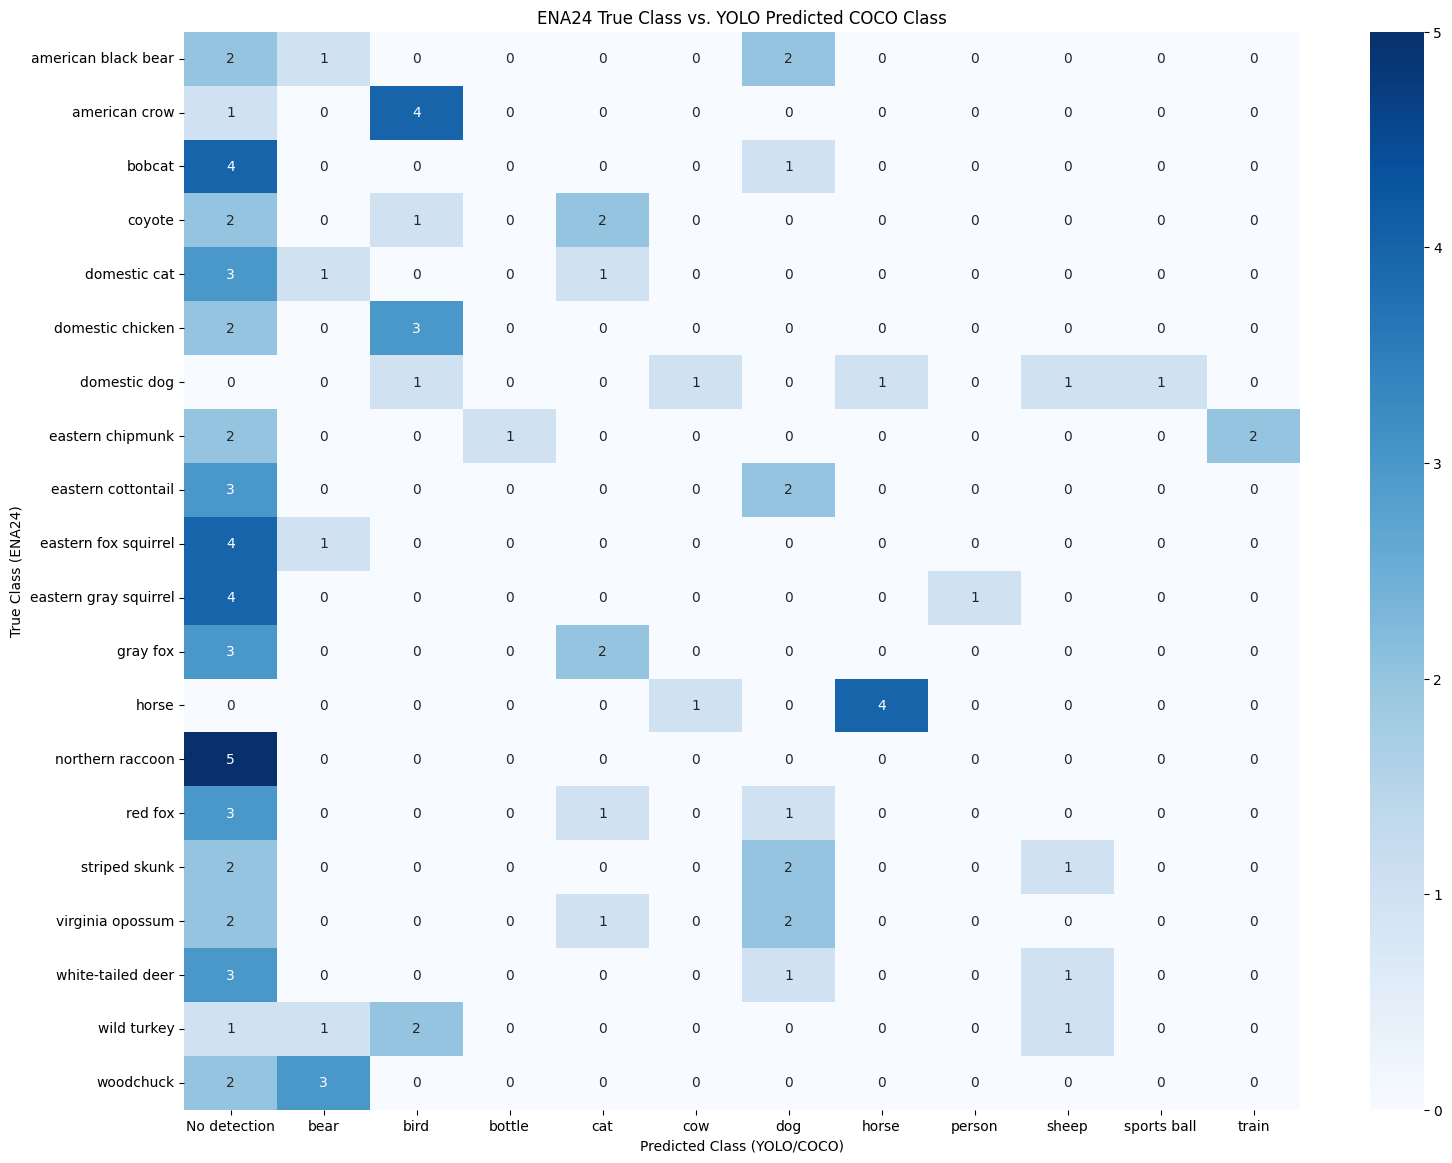

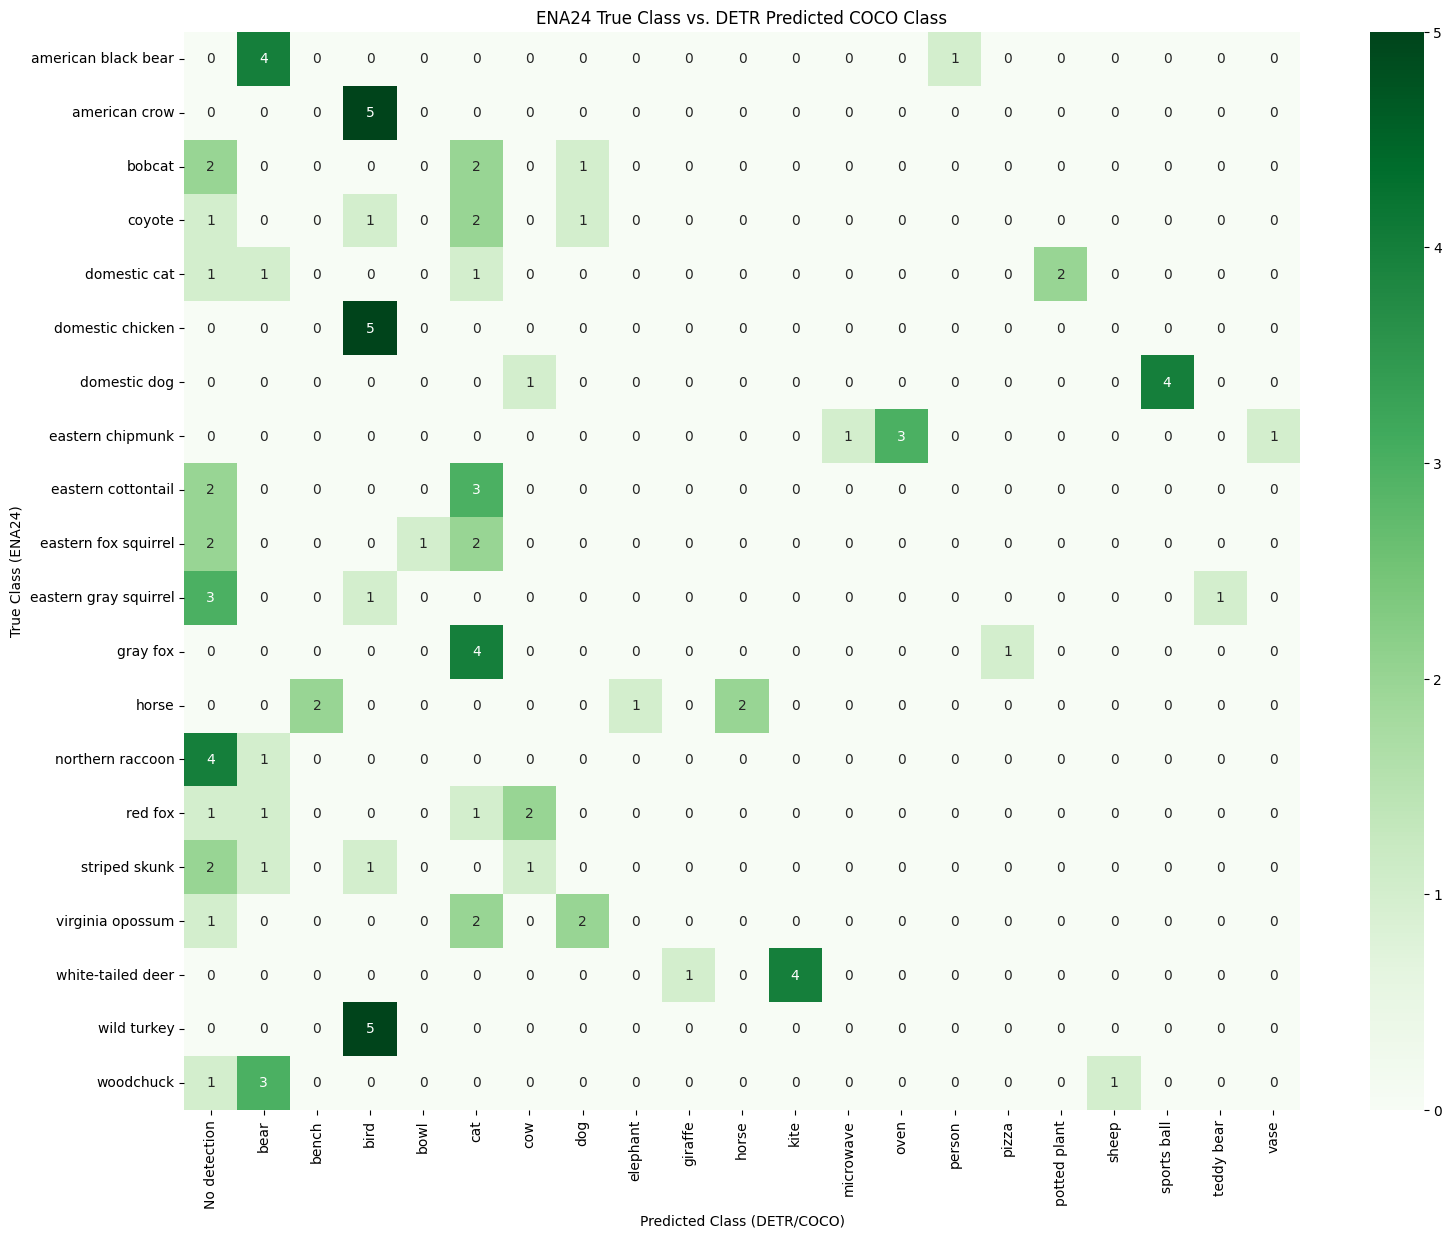

In [10]:
# --- YOLO Crosstab ---
df_yolo = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred_yolo})
yolo_crosstab = pd.crosstab(df_yolo['y_true'], df_yolo['y_pred'], rownames=['True Class (ENA24)'], colnames=['Predicted Class (YOLO/COCO)'])

plt.figure(figsize=(18, 14))
sns.heatmap(yolo_crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('ENA24 True Class vs. YOLO Predicted COCO Class')
plt.show()

# --- DETR Crosstab ---
df_detr = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred_detr})
detr_crosstab = pd.crosstab(df_detr['y_true'], df_detr['y_pred'], rownames=['True Class (ENA24)'], colnames=['Predicted Class (DETR/COCO)'])

plt.figure(figsize=(18, 14))
sns.heatmap(detr_crosstab, annot=True, fmt='d', cmap='Greens')
plt.title('ENA24 True Class vs. DETR Predicted COCO Class')
plt.show()

### 5.4. Evaluating DETR with a ROC Curve

To dig deeper into DETR's performance, we can generate a Receiver Operating Characteristic (ROC) curve. This will help us quantify how well the model can distinguish between a target class and other classes based on its confidence scores.

Since the ENA24 `bird` class has a direct counterpart in the COCO dataset, we can formulate a binary classification problem:
*   **Positive Class**: Images from ENA24 labeled as `bird`.
*   **Negative Class**: Images of all other animals in our ENA24 sample.
*   **Prediction Score**: For each image, we take the highest score that DETR assigns to the COCO `bird` class across all of its object queries.

The resulting ROC curve shows the trade-off between the True Positive Rate (correctly identifying birds) and the False Positive Rate (incorrectly labeling other animals as birds) at various confidence thresholds.

In [ ]:
# Import necessary functions for ROC curve
from sklearn.metrics import roc_curve, auc

# We will evaluate DETR's ability to distinguish the 'bird' class from other animals.
# Positives: Images of birds from ENA24
# Negatives: Images of other animals from ENA24
# Score: The model's maximum confidence score for the COCO 'bird' class.

ground_truth = []
prediction_scores = []

# Find the class ID for 'bird' in the DETR model's config
bird_class_id = None
for k, v in model_detr.config.id2label.items():
    if v == 'bird':
        bird_class_id = k
        break

print(f"COCO 'bird' class ID: {bird_class_id}")

if bird_class_id is None:
    raise Exception("Bird class not found")

print("Generating scores for ROC curve...")
for name in tqdm.tqdm(unique_common_names):
    sample_images = ena24_df[ena24_df['common_name'] == name].head(20)
    
    for index, row in sample_images.iterrows():
        image_relative_path = row['filepath']
        full_image_path = os.path.join(base_data_path, 'data/test/', image_relative_path)
        
        if os.path.exists(full_image_path):
            try:
                img = Image.open(full_image_path).convert("RGB")
                
                # Define ground truth: 1 if bird, 0 otherwise
                is_bird = 1 if name in ['american crow', 'domestic chicken', 'wild turkey'] else 0
                ground_truth.append(is_bird)

                # --- Get DETR score for the 'bird' class ---
                inputs = processor_detr(images=img, return_tensors="pt").to(device)
                with torch.no_grad():
                    outputs = model_detr(**inputs)
                
                # Get probabilities for all classes (excluding 'no object')
                probs = outputs.logits.softmax(-1)[0, :, :-1]
                
                # Get the scores for the 'bird' class across all object queries
                bird_scores = probs[:, bird_class_id]
                
                # The final score is the maximum score for 'bird' in this image
                max_bird_score = bird_scores.max().item()
                prediction_scores.append(max_bird_score)
                print(name, index, max_bird_score, is_bird)

            except Exception as e:
                print(f"Could not process image {full_image_path}: {e}")

print("Finished generating scores.")

# --- Calculate and Plot ROC Curve ---
fpr, tpr, thresholds = roc_curve(ground_truth, prediction_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DETR ROC Curve for "bird" class detection on ENA24')
plt.legend(loc="lower right")
plt.show()

COCO 'bird' class ID: 16
Generating scores for ROC curve...


  0%|                                                                                                                                                      | 0/20 [00:00<?, ?it/s]

eastern chipmunk 0 2.2997489850240527e-06 0
eastern chipmunk 1 3.605251094995765e-06 0
eastern chipmunk 2 1.8374057617620565e-06 0
eastern chipmunk 3 0.9577280879020691 0
eastern chipmunk 4 2.7744049475586507e-06 0
eastern chipmunk 5 7.222207386803348e-06 0
eastern chipmunk 6 3.457715138210915e-06 0
eastern chipmunk 7 9.954322877092636e-07 0
eastern chipmunk 9 6.758379811344639e-08 0
eastern chipmunk 10 0.007596632000058889 0
eastern chipmunk 11 0.004967181943356991 0
eastern chipmunk 12 9.571674581820844e-07 0
eastern chipmunk 13 3.754256994170646e-08 0
eastern chipmunk 14 4.0935749012760425e-08 0
eastern chipmunk 15 1.1501289698401251e-08 0
eastern chipmunk 16 0.7918090224266052 0
eastern chipmunk 17 1.5857532176255518e-08 0
eastern chipmunk 18 3.456115749145283e-08 0
eastern chipmunk 19 9.141203349827265e-07 0


  5%|███████                                                                                                                                       | 1/20 [00:01<00:24,  1.27s/it]

eastern chipmunk 20 0.00015569673269055784 0
eastern gray squirrel 8 0.00026656888076104224 0
eastern gray squirrel 25 0.001974264159798622 0
eastern gray squirrel 28 0.0013677424285560846 0
eastern gray squirrel 32 0.0018689441494643688 0
eastern gray squirrel 36 0.9492877125740051 0
eastern gray squirrel 53 0.00063672213582322 0
eastern gray squirrel 58 0.0010455392766743898 0
eastern gray squirrel 60 0.0002404127735644579 0
eastern gray squirrel 76 0.0002898788661696017 0
eastern gray squirrel 82 0.0010282978182658553 0
eastern gray squirrel 91 0.08762586861848831 0
eastern gray squirrel 96 8.717367745703086e-05 0
eastern gray squirrel 106 2.632888572406955e-05 0
eastern gray squirrel 109 0.001961847534403205 0
eastern gray squirrel 123 0.0028482265770435333 0
eastern gray squirrel 126 0.0622711218893528 0
eastern gray squirrel 139 8.017089385248255e-06 0
eastern gray squirrel 150 0.2890665531158447 0
eastern gray squirrel 153 0.00013133003085386008 0


 10%|██████████████▏                                                                                                                               | 2/20 [00:02<00:23,  1.32s/it]

eastern gray squirrel 170 1.3398253031482454e-05 0
woodchuck 42 0.0006122306804172695 0
woodchuck 43 1.684913513599895e-05 0
woodchuck 44 2.2489799448521808e-05 0
woodchuck 45 0.001167052541859448 0
woodchuck 46 0.0002579440188128501 0
woodchuck 47 0.013105962425470352 0
woodchuck 48 0.004808497149497271 0
woodchuck 49 3.002725679834839e-05 0
woodchuck 50 0.01246631145477295 0
woodchuck 51 0.0004878766485489905 0
woodchuck 52 0.0017173228552564979 0
woodchuck 54 0.9386259317398071 0
woodchuck 55 0.00015272226301021874 0
woodchuck 56 0.0003099373425357044 0
woodchuck 57 0.0005391152226366103 0
woodchuck 59 9.641890210332349e-05 0
woodchuck 61 0.8238376975059509 0
woodchuck 62 0.9632538557052612 0
woodchuck 63 0.032610878348350525 0


 15%|█████████████████████▎                                                                                                                        | 3/20 [00:03<00:22,  1.30s/it]

woodchuck 64 0.9209381937980652 0
wild turkey 105 0.9971787929534912 1
wild turkey 107 0.9744618535041809 1
wild turkey 108 0.9975503087043762 1
wild turkey 110 0.9986901879310608 1
wild turkey 111 0.9980899691581726 1
wild turkey 112 0.9888311624526978 1
wild turkey 113 0.001871059532277286 1
wild turkey 114 9.824751941778231e-06 1
wild turkey 115 0.9361196160316467 1
wild turkey 116 0.00010155123163713142 1
wild turkey 117 5.530743146664463e-05 1
wild turkey 118 3.284190097474493e-05 1
wild turkey 119 0.027037514373660088 1
wild turkey 120 7.66236407798715e-05 1
wild turkey 121 5.848301589139737e-05 1
wild turkey 122 5.992050137137994e-05 1
wild turkey 124 0.998422384262085 1
wild turkey 125 0.999222993850708 1


 20%|████████████████████████████▍                                                                                                                 | 4/20 [00:05<00:20,  1.29s/it]

wild turkey 127 0.9553411602973938 1
wild turkey 128 0.9852596521377563 1
white-tailed deer 149 0.00017071908223442733 0
white-tailed deer 151 0.00047882358194328845 0
white-tailed deer 152 0.03891290724277496 0
white-tailed deer 154 0.0006162707577459514 0
white-tailed deer 155 0.006658034399151802 0
white-tailed deer 156 0.0013512776931747794 0
white-tailed deer 157 0.007339153438806534 0
white-tailed deer 158 0.0012023267336189747 0
white-tailed deer 159 0.0013482493814080954 0
white-tailed deer 160 0.018355652689933777 0
white-tailed deer 161 0.0031463350169360638 0
white-tailed deer 162 0.0003766693698707968 0
white-tailed deer 163 0.11894197762012482 0
white-tailed deer 164 0.10689038783311844 0
white-tailed deer 165 0.0002873076300602406 0
white-tailed deer 166 0.0010653675999492407 0
white-tailed deer 167 0.0004833501880057156 0
white-tailed deer 168 4.449848347576335e-05 0


 25%|███████████████████████████████████▌                                                                                                          | 5/20 [00:06<00:18,  1.26s/it]

white-tailed deer 169 3.158555773552507e-05 0
white-tailed deer 172 0.34138551354408264 0
virginia opossum 203 0.0007336765411309898 0
virginia opossum 204 0.0013513246085494757 0
virginia opossum 205 0.003695938503369689 0
virginia opossum 206 0.12111591547727585 0
virginia opossum 207 0.03798992186784744 0
virginia opossum 209 0.0012162372004240751 0
virginia opossum 212 0.01889823190867901 0
virginia opossum 215 0.0006141870399005711 0
virginia opossum 217 0.017100421711802483 0
virginia opossum 218 0.004471747204661369 0
virginia opossum 219 0.0014960954431444407 0
virginia opossum 220 0.022339768707752228 0
virginia opossum 222 0.26038509607315063 0
virginia opossum 224 0.20121604204177856 0
virginia opossum 225 0.0009053754038177431 0
virginia opossum 227 3.613330773077905e-05 0
virginia opossum 228 0.0920497477054596 0


 30%|██████████████████████████████████████████▌                                                                                                   | 6/20 [00:07<00:18,  1.29s/it]

virginia opossum 229 0.019925003871321678 0
virginia opossum 230 0.9221121072769165 0
virginia opossum 231 0.0003134278813377023 0
eastern cottontail 213 0.010935209691524506 0
eastern cottontail 214 7.975783955771476e-05 0
eastern cottontail 806 0.001445917645469308 0
eastern cottontail 811 0.002379307057708502 0
eastern cottontail 814 4.272575824870728e-05 0
eastern cottontail 818 0.0024788533337414265 0
eastern cottontail 821 0.0031599602662026882 0
eastern cottontail 827 0.013078066520392895 0
eastern cottontail 835 0.003448574338108301 0
eastern cottontail 839 0.0012917730491608381 0
eastern cottontail 842 0.004842767491936684 0
eastern cottontail 861 0.0008686220389790833 0
eastern cottontail 876 0.0016631589969620109 0
eastern cottontail 887 0.018278272822499275 0
eastern cottontail 892 9.679191862232983e-06 0
eastern cottontail 907 0.09926927089691162 0


From the heatmaps, we can see how the models perform. For example, both models often correctly map the ENA24 `bird` class to the COCO `bird` class. However, for species not in COCO, like `red_deer` or `wild_boar`, the models might predict related classes like `cow`, `horse`, or `dog`, or simply fail to make a detection. This analysis highlights the limitations of using pretrained models on novel domains and underscores the need for fine-tuning.

## 6. Head-to-Head Comparison: YOLO vs. DETR

| Feature               | YOLOv8                                        | DETR                                                       |
| --------------------- | --------------------------------------------- | ---------------------------------------------------------- |
| **Architecture**      | CNN-based (CSPDarknet Backbone, PANet Neck)   | Hybrid (CNN Backbone + Transformer Encoder/Decoder)        |
| **Prediction**        | Predicts on a dense grid across the image     | Predicts a sparse set of objects via object queries        |
| **Post-processing**   | Requires Non-Maximum Suppression (NMS)        | End-to-end; minimal or no NMS required                     |
| **Ease of Use**       | Very simple via `ultralytics` library         | More complex; requires manual processing via `transformers`|
| **Core Idea**         | Fast, single-stage regression and classification | Direct set prediction, treating detection as a dictionary lookup |

## 7. Conclusion

In this notebook, we explored two state-of-the-art object detection models.
*   **YOLOv8** is incredibly fast and easy to use, making it an excellent choice for real-time applications where speed is critical. Its reliance on NMS is a defining characteristic of single-stage detectors.
*   **DETR** represents a newer paradigm, using a transformer architecture to perform end-to-end detection. This removes the need for hand-tuned components like NMS and can lead to better performance, though often at the cost of higher computational requirements and implementation complexity.

Our analysis on the ENA24 dataset showed that while pretrained models are a fantastic starting point, their performance on specialized domains is limited by their training data. To achieve high accuracy on ENA24's specific animal classes, the clear next step is **fine-tuning**, where we would train these models further on the ENA24 data itself.